In [54]:
import jax
import jax.numpy as jnp
import jax.random as jrandom
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
%matplotlib inline
import functools as ft
import optax
import equinox as eqx
from sdf_jax import NeuralSDF, plot2d

# Implicit Geometric Regularization

"Implicit Geometric Regularization for Learning Shapes"
Gropp et al. ICML 2020
https://arxiv.org/abs/2002.10099


![](igr_loss.png)

In [64]:
def surface_loss_fn(model, x):
    return jnp.abs(x)

def eikonal_loss_fn(model, x):
    return (jnp.linalg.norm(jax.grad(model)(x)) - 1.0)**2

def batch_loss_fn(model, xs, key, *, lam, n_samples=20):
    surface_loss = jnp.mean(jax.vmap(ft.partial(surface_loss_fn, model))(xs))
    xs_eik = jrandom.uniform(key, (n_samples, 2))
    eikonal_loss = jnp.mean(jax.vmap(ft.partial(eikonal_loss_fn, model))(xs))
    return surface_loss + eikonal_loss

@eqx.filter_jit
def make_step(model, xs, opt_state, opt_update, lam, key):
    loss_fn = eqx.filter_value_and_grad(batch_loss_fn)
    loss, grads = loss_fn(model, xs, key, lam=lam)
    updates, opt_state = opt_update(grads, opt_state)
    model = eqx.apply_updates(model, updates)
    return loss, model, opt_state

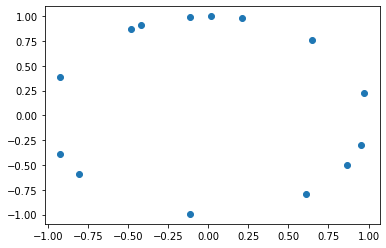

In [65]:
key = jax.random.PRNGKey(0)
key, theta_key = jrandom.split(key, 2)
theta = 2 * jnp.pi * jrandom.uniform(theta_key, (14,))
xs = jnp.vstack([jnp.cos(theta), jnp.sin(theta)]).T
plt.scatter(*xs.T)

In [66]:
jrandom.choice(key, xs, (3,))

DeviceArray([[ 0.01673735,  0.9998599 ],
             [ 0.01673735,  0.9998599 ],
             [-0.48378474,  0.87518704]], dtype=float32)

Step=499 Loss=0.6308706998825073


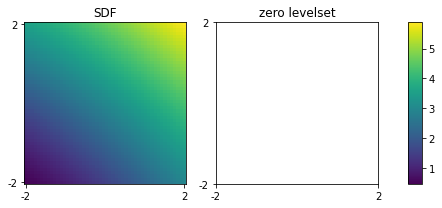

In [71]:
num_steps = 500
batch_size = 10
lr = 5e-3
print_every = 50
lam = 1.0

key = jax.random.PRNGKey(0)
key, theta_key = jrandom.split(key, 2)
theta = 2 * jnp.pi * jrandom.uniform(theta_key, (14,))
xs = jnp.vstack([jnp.cos(theta), jnp.sin(theta)]).T
print(xs.shape)

key, model_key, data_key = jrandom.split(key, 3)
model = NeuralSDF(in_size=2, 
                  width_size=5, 
                  depth=3, 
                  activation=jax.nn.softplus,
                  key=model_key)
opt = optax.adam(lr)
opt_state = opt.init(eqx.filter(model, eqx.is_inexact_array))
for i in range(num_steps):
    key, batch_key, loss_key = jrandom.split(key, 3)
    xs_batch = jrandom.choice(batch_key, xs, (batch_size,))
    loss, model, opt_state = make_step(model, xs_batch, opt_state, opt.update, lam, loss_key)
    if (i % print_every) == 0 or i == num_steps - 1:
        clear_output(True)
        print(f"Step={i} Loss={loss}")
        plot2d(model, ngrid=50)
        plt.show()